<a href="https://colab.research.google.com/github/khaledmohamed00/Facial_key_points_detection_pytorch/blob/master/facial_key_points_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-pyd7aomz
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-pyd7aomz
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=61995 sha256=59a5df010cccddfe72e0240aef1b7a27129df934c97b987b3f38491ac4408c5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2e7kmpp/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.4
    Uninstalling albumentations-0.4.4:
      Successfully uninstalled albumentations-0.4.4



Data Loading and Processing Tutorial
====================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

A lot of effort in solving any machine learning problem goes in to
preparing the data. PyTorch provides many tools to make data loading
easy and hopefully, to make your code more readable. In this tutorial,
we will see how to load and preprocess/augment data from a non trivial
dataset.

To run this tutorial, please make sure the following packages are
installed:

-  ``scikit-image``: For image io and transforms
-  ``pandas``: For easier csv parsing




In [0]:
!unzip '/content/drive/My Drive/faces.zip'

Archive:  /content/drive/My Drive/faces.zip
   creating: faces/
  inflating: faces/0805personali01.jpg  
  inflating: faces/1084239450_e76e00b7e7.jpg  
  inflating: faces/10comm-decarlo.jpg  
  inflating: faces/110276240_bec305da91.jpg  
  inflating: faces/1198_0_861.jpg    
  inflating: faces/137341995_e7c48e9a75.jpg  
  inflating: faces/1383023626_8a49e4879a.jpg  
  inflating: faces/144044282_87cf3ff76e.jpg  
  inflating: faces/152601997_ec6429a43c.jpg  
  inflating: faces/1549040388_b99e9fa295.jpg  
  inflating: faces/1878519279_f905d4f34e.jpg  
  inflating: faces/2046713398_91aaa6fe1c.jpg  
  inflating: faces/2173711035_dbd53b4f9f.jpg  
  inflating: faces/2210514040_6b03ff2629.jpg  
  inflating: faces/2322901504_08122b01ba.jpg  
  inflating: faces/2327253037_66a61ea6fe.jpg  
  inflating: faces/2328398005_d328a70b4c.jpg  
  inflating: faces/2370961440_6bc8ce346c.jpg  
  inflating: faces/2382SJ8.jpg       
  inflating: faces/252418361_440b75751b.jpg  
  inflating: faces/262007783_943

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The dataset we are going to deal with is that of facial pose.
This means that a face is annotated like this:

.. figure:: /_static/img/landmarked_face2.png
   :width: 400

Over all, 68 different landmark points are annotated for each face.

<div class="alert alert-info"><h4>Note</h4><p>Download the dataset from `here <https://download.pytorch.org/tutorial/faces.zip>`_
    so that the images are in a directory named 'faces/'.
    This dataset was actually
    generated by applying excellent `dlib's pose
    estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`__
    on a few images from imagenet tagged as 'face'.</p></div>

Dataset comes with a csv file with annotations which looks like this:

::

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

Let's quickly read the CSV and get the annotations in an (N, 2) array where N
is the number of landmarks.




In [0]:
landmarks_frame = pd.read_csv('/content/faces/face_landmarks.csv')
#print(len(landmarks_frame))
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [0]:
def pre_process_landmarks(landmarks_frame):
    landmarks_list=[]
    for i in range(len(landmarks_frame)):
        img_name = landmarks_frame.iloc[n, 0]
        landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)  
        landmarks_list.append(landmarks)
    landmarks_list=np.array(landmarks_list)
    #print(landmarks_list.shape)
    max_landmark0=landmarks_list[:,:,0].max()
    min_landmark0=landmarks_list[:,:,0].min()
    max_landmark1=landmarks_list[:,:,1].max()
    min_landmark1=landmarks_list[:,:,1].min()
    print(max_landmark0,min_landmark0)
    print(max_landmark1,min_landmark1)
    landmarks_0=[min_landmark0,max_landmark0]
    landmarks_1=[min_landmark1,max_landmark1]

    return landmarks_0,landmarks_1
landmarks_0,landmarks_1=pre_process_landmarks(landmarks_frame)

122.0 32.0
127.0 44.0


Let's write a simple helper function to show an image and its landmarks
and use it to show a sample.




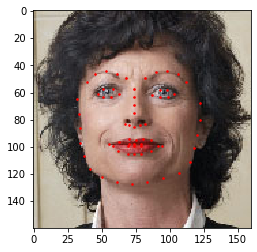

In [0]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our datset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,csv_file, root_dir,transform=None,augment=None,image_size=(256,256)):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.augment=augment
        if self.transform:
           landmarks_0,landmarks_1=self.landmarks_normalization_params(landmarks_frame,image_size)
        else:
           landmarks_0,landmarks_1=self.landmarks_normalization_params(landmarks_frame,image_size=None)

        self.landmarks_0=landmarks_0
        self.landmarks_1=landmarks_1

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = np.array(landmarks).astype('float').reshape(-1, 2)
        #landmarks=self.landmarks_normalization(landmarks)
        
        #landmarks[:,0]=(landmarks[:,0]-self.landmarks_0[0])/self.landmarks_0[1]
        #landmarks[:,1]=(landmarks[:,1]-self.landmarks_1[0])/self.landmarks_1[1]
        
        sample = {'image': image, 'landmarks': landmarks}
        if self.augment:
          sam=self.augment(image=sample['image'])
          sample['image']=sam['image']
        if self.transform:
            sample = self.transform(sample)
        sample['landmarks']=self.landmarks_normalization(sample['landmarks'])
        
        return sample
    def landmarks_normalization_params(self,landmarks_frame,image_size):
        landmarks_list=[]
        for i in range(len(landmarks_frame)):
            img_name = landmarks_frame.iloc[n, 0]
            img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[i, 0])
            image = io.imread(img_name)
            image=np.array(image)

            landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
            landmarks = landmarks.astype('float').reshape(-1, 2)
            if image_size:
               landmarks=landmarks*[(image_size[0]*1.0) /image.shape[0], (1.0*image_size[1]) /image.shape[1]]  
            landmarks_list.append(landmarks)
        landmarks_list=np.array(landmarks_list)
        max_landmark0=landmarks_list[:,:,0].max()
        min_landmark0=landmarks_list[:,:,0].min()
        max_landmark1=landmarks_list[:,:,1].max()
        min_landmark1=landmarks_list[:,:,1].min()
        landmarks_0=[min_landmark0,max_landmark0]
        landmarks_1=[min_landmark1,max_landmark1]
        return landmarks_0,landmarks_1


    def landmarks_denormalization(self,landmarks):
        landmarks[:,0]=(landmarks[:,0]*self.landmarks_0[1])+self.landmarks_0[0]
        landmarks[:,1]=(landmarks[:,1]*self.landmarks_1[1])+self.landmarks_1[0]
        return landmarks        

    def landmarks_normalization(self,landmarks):
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        landmarks[:,0]=(landmarks[:,0]-self.landmarks_0[0])/self.landmarks_0[1]
        landmarks[:,1]=(landmarks[:,1]-self.landmarks_1[0])/self.landmarks_1[1]
        return landmarks    

Let's instantiate this class and iterate through the data samples. We
will print the sizes of first 4 samples and show their landmarks.




0 (324, 215, 3) (68, 2)


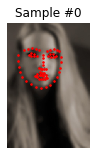

1 (500, 333, 3) (68, 2)


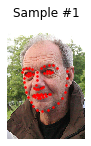

2 (250, 258, 3) (68, 2)


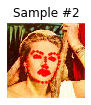

3 (434, 290, 3) (68, 2)


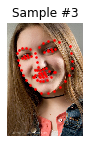

In [0]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    sample['landmarks']=face_dataset.landmarks_denormalization(sample['landmarks'])
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Transforms
----------

One issue we can see from the above is that the samples are not of the
same size. Most neural networks expect the images of a fixed size.
Therefore, we will need to write some prepocessing code.
Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. We can then use a transform like this:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

Observe below how these transforms had to be applied both on the image and
landmarks.




In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,IAAAdditiveGaussianNoise,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, ElasticTransform, ChannelShuffle,RGBShift, Rotate
)


def get_training_augmentation():
    train_transform = [

        #ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        IAAAdditiveGaussianNoise(p=1.0),
        IAAPerspective(p=1.0),

        OneOf(
            [
                CLAHE(p=1.0),
                RandomBrightness(p=1.0),
                RandomGamma(p=1.0),
            ],
            p=1.0,
        ),

        OneOf(
            [
                IAASharpen(p=1.0),
                Blur(blur_limit=3, p=1.0),
                MotionBlur(blur_limit=3, p=1.0),
            ],
            p=1.0,
        ),

        OneOf(
            [
                RandomContrast(p=1.0),
                HueSaturationValue(p=1.0),
            ],
            p=1.0,
        ),
        #Lambda(mask=round_clip_0_1)
    ]
    return Compose(train_transform)

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        '''
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
        
        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        '''
        #img = transform.resize(image, (new_h, new_w))
        img = transform.resize(image, (self.output_size[0], self.output_size[1]))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        #landmarks = landmarks * [new_w / w, new_h / h]
        landmarks = landmarks * [self.output_size[0] / w, self.output_size[1] / h]
        
        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Compose transforms
~~~~~~~~~~~~~~~~~~

Now, we apply the transforms on an sample.

Let's say we want to rescale the shorter side of the image to 256 and
then randomly crop a square of size 224 from it. i.e, we want to compose
``Rescale`` and ``RandomCrop`` transforms.
``torchvision.transforms.Compose`` is a simple callable class which allows us
to do this.




(250, 258, 3)
(256, 256, 3)


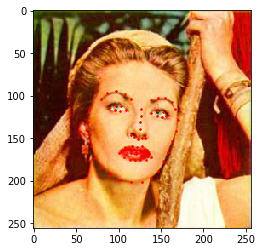

In [0]:
scale = Rescale((256,256))
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[2]
print(sample['image'].shape)
'''
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print(transformed_sample['image'].shape)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
'''
sample['landmarks']=face_dataset.landmarks_denormalization(sample['landmarks'])

transformed_sample=scale(sample)
print(transformed_sample['image'].shape)
show_landmarks(**transformed_sample)


#plt.show()

Iterating through the dataset
-----------------------------

Let's put this all together to create a dataset with composed
transforms.
To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range``
loop as before.




In [0]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale((256,256)),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ]),
                                           augment=get_training_augmentation())

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 256, 256]) torch.Size([68, 2])
1 torch.Size([3, 256, 256]) torch.Size([68, 2])
2 torch.Size([3, 256, 256]) torch.Size([68, 2])
3 torch.Size([3, 256, 256]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.




0 torch.Size([4, 3, 256, 256]) torch.Size([4, 136])
1 torch.Size([4, 3, 256, 256]) torch.Size([4, 136])
2 torch.Size([4, 3, 256, 256]) torch.Size([4, 136])
3 torch.Size([4, 3, 256, 256]) torch.Size([4, 136])


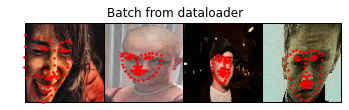

In [0]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        landmarks_batch[i]=transformed_dataset.landmarks_denormalization(landmarks_batch[i])
        plt.scatter(landmarks_batch[i, :, 0].numpy()+ i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].view(-1,sample_batched['landmarks'].size()[1]*sample_batched['landmarks'].size()[2]).size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

Afterword: torchvision
----------------------

In this tutorial, we have seen how to write and use datasets, transforms
and dataloader. ``torchvision`` package provides some common datasets and
transforms. You might not even have to write custom classes. One of the
more generic datasets available in torchvision is ``ImageFolder``.
It assumes that images are organized in the following way: ::

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

where 'ants', 'bees' etc. are class labels. Similarly generic transforms
which operate on ``PIL.Image`` like  ``RandomHorizontalFlip``, ``Scale``,
are also available. You can use these to write a dataloader like this: ::

  import torch
  from torchvision import transforms, datasets

  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
  hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                             transform=data_transform)
  dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)

For an example with training code, please see
:doc:`transfer_learning_tutorial`.



In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1=nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3,padding=1)
        self.batch_norm2=nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,32, 3,padding=1)
        self.batch_norm3=nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32,64, 3,padding=1)
        self.batch_norm4=nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64,64, 3,padding=1)
        self.batch_norm5=nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64,64, 3,padding=1)

        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(512, 136)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x=  self.batch_norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x=  self.batch_norm2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x=  self.batch_norm3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x=  self.batch_norm4(x)
        x = self.pool(F.relu(self.conv5(x)))
        x=  self.batch_norm5(x)
        x = self.pool(F.relu(self.conv6(x)))

        x = x.view(-1, self.num_flat_features(x))
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        #print(size)
        num_features = 1
        for s in size:
            num_features *= s

        #print(num_features)    
        return num_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().float().train()
net=net.to(device)
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 256, 256]             168
         MaxPool2d-2          [-1, 6, 128, 128]               0
       BatchNorm2d-3          [-1, 6, 128, 128]              12
            Conv2d-4         [-1, 16, 128, 128]             880
         MaxPool2d-5           [-1, 16, 64, 64]               0
       BatchNorm2d-6           [-1, 16, 64, 64]              32
            Conv2d-7           [-1, 32, 64, 64]           4,640
         MaxPool2d-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 64, 32, 32]          18,496
        MaxPool2d-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
           Conv2d-13           [-1, 64, 16, 16]          36,928
        MaxPool2d-14             [-1, 6

In [0]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [0]:
#net = torch.load('/content/drive/My Drive/face_model')
net.train()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3)

In [0]:
epoch_loss_list=[]
for epoch in range(200):  # loop over the dataset multiple times
    epoch_loss=0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data['image'],data['landmarks']
        inputs, labels = inputs.float().to(device), labels.view(-1,labels.size()[1]*labels.size()[2]).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        #labels=labels.view(-1,labels.size()[1]*labels.size()[2])
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #print(outputs.size(),labels.size())
        loss.backward()
        optimizer.step()
        #print(outputs)
        #print(labels)
        
        # print statistics
        running_loss += loss.item()

    epoch_loss= running_loss/(i+1)
    print('[%d, %5d] loss: %.5f'%(epoch + 1, i + 1, epoch_loss))
    epoch_loss_list.append(epoch_loss)

        #print(loss.item())
print('Finished Training')

[1,    18] loss: 0.001
[2,    18] loss: 0.001
[3,    18] loss: 0.001
[4,    18] loss: 0.001
[5,    18] loss: 0.001
[6,    18] loss: 0.001
[7,    18] loss: 0.001
[8,    18] loss: 0.001
[9,    18] loss: 0.001
[10,    18] loss: 0.001
[11,    18] loss: 0.001
[12,    18] loss: 0.001
[13,    18] loss: 0.001
[14,    18] loss: 0.001
[15,    18] loss: 0.001
[16,    18] loss: 0.001
[17,    18] loss: 0.001
[18,    18] loss: 0.001
[19,    18] loss: 0.001
[20,    18] loss: 0.001
[21,    18] loss: 0.001
[22,    18] loss: 0.001
[23,    18] loss: 0.002
[24,    18] loss: 0.002
[25,    18] loss: 0.001
[26,    18] loss: 0.002
[27,    18] loss: 0.001
[28,    18] loss: 0.002
[29,    18] loss: 0.001
[30,    18] loss: 0.001
[31,    18] loss: 0.001
[32,    18] loss: 0.001
[33,    18] loss: 0.001
[34,    18] loss: 0.001
[35,    18] loss: 0.001
[36,    18] loss: 0.001
[37,    18] loss: 0.001
[38,    18] loss: 0.001
[39,    18] loss: 0.001
[40,    18] loss: 0.001
[41,    18] loss: 0.001
[42,    18] loss: 0.001
[

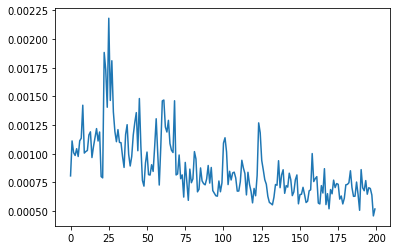

In [0]:
plt.plot(epoch_loss_list)

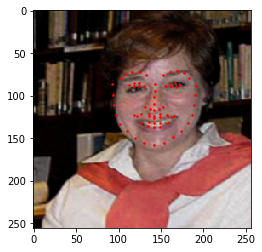

In [0]:
net.float().eval()
with torch.no_grad():
     dataiter = iter(dataloader)
     data = dataiter.next()
     inputs, labels = data['image'].float(),data['landmarks']
     pred=net(inputs)
     pred = pred[0].reshape(-1, 2)
     pred=transformed_dataset.landmarks_denormalization(pred)
     show_landmarks(inputs[0].numpy().transpose((1, 2, 0)), pred)




     

In [0]:
torch.save(net,'face01_model')


In [0]:
net = torch.load('/content/drive/My Drive/face_model')


In [0]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3)